#Tosi et al Benchmark

In [1]:
%%javascript
IPython.load_extensions('calico-document-tools');

<IPython.core.display.Javascript object>

This notebook generates models from the <a name="ref-1"/>[(Tosi et al., 2015)](#cite-tosi2015community) Benchmark in Underworld2. The Underworld results are compared to the benchmark model run on Fenics. Input files for the Fenics models were provided by Petra Maierova. The comparison of Underworld2 and Fenics is useful because both are FEM codes which can be built Python environment and both interface to PetSc to solve the linear systems. 

In [2]:
# RT PIC - classic and nearest neighbour
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np
import os

In [3]:
dim = 2
xnum = 128
ynum = 128

In [4]:
# create mesh objects
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("linear","constant"), 
                                         elementRes=(xnum,ynum), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,1.)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

In [5]:
# create fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

In [6]:
# create some dummy fevariables for doing top and bottom boundary integrations
topField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
bottomField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)

topField.numpyArray[:] = 0.
bottomField.numpyArray[:] = 0.

# lets ensure temp boundaries are still what we want 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]():
    bottomField.numpyArray[index] = 1.
for index in linearMesh.specialSets["MaxJ_VertexSet"]():
    topField.numpyArray[index] = 1.

#ICs and BCs

In [7]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.numpyArray[:] = [0.,0.]
pressureField.numpyArray[:] = 0.
temperatureField.numpyArray[:] = 0.

# Setup temperature initial condition via numpy arrays
toptemp = 0.
bottomtemp = 1.
A = 0.01
import math
#Note that width = height = 1
tempNump = temperatureField.numpyArray
for index, coord in enumerate(linearMesh.numpyArray):
    pertCoeff = (1- coord[1]) + A*math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    tempNump[index] = pertCoeff;

###Fenics ICs for comparison

    u_init = Expression(("0", "0", "0")) # zero
    temp_init = Expression("(1 - x[1]) + 0.01*cos(pi*x[0]/width)*sin(pi*x[1]/height)",
                        width=width, height=height)


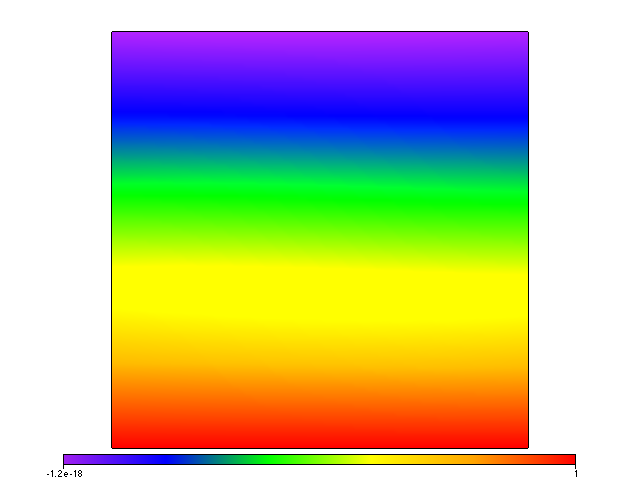

In [8]:
figtemp = plt.Figure()
tempminmax = fn.view.min_max(temperatureField)
figtemp.Surface(tempminmax, elementMesh)
figtemp.show()

In [9]:
# Get list of special sets.
# These are sets of vertices on the mesh. In this case we want to set them as boundary conditions.
linearMesh.specialSets.keys()

['AllWalls',
 'MaxI_VertexSet',
 'MinJ_VertexSet',
 'MinI_VertexSet',
 'MaxJ_VertexSet']

In [10]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"]() + linearMesh.specialSets["MaxI_VertexSet"]()
JWalls = linearMesh.specialSets["MinJ_VertexSet"]() + linearMesh.specialSets["MaxJ_VertexSet"]()

In [11]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [12]:
# lets ensure temp boundaries are still what we want 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]():
    temperatureField.numpyArray[index] = 1.
for index in linearMesh.specialSets["MaxJ_VertexSet"]():
    temperatureField.numpyArray[index] = 0.

#Rheology

##Arrhenius / Frank-Kameneski

The temperature dependence of the mantle viscosity is usually expressed with the Arrhenius law:

$\eta(T) = C exp\frac{E}{RT} $

The Frank-Kamenetski (FK) approximation linearizes the exponential term. The FK approximation has theoretically almost no effect on the convecting part of the mantle, but the increase of the viscosity towards the surface is much weaker and the local and global viscosity contrasts are code friendlier.

i.e. for temperature dependence:

$\eta(T) = A exp(−bT)$

In this benchmark, the FK approximation encompasses both temperature and pressure dependence (pressure is paramaterized by depth) and is given as:

$\eta_{lin}(T,z) = exp(−\gamma_T T + \gamma_z z)$


##Plasticity

This benchmark uses an averaging term for the effective viscosity, whereas Underworld typically takes the miniumum of the linear or non-linear visocosity. Also, non-linear iterations are by defualt performed using the Newton method. However we can equally easily build an average form for the effective viscosity and perform Picard iterations all in Python.

There are some differences in the definition of the second invariant of a symmetric tensor, that we need to be aware of. The symmetric part of the strain rate is the first term in the following decomposition:


$$\nabla v = \frac{1}{2}\left[\nabla \bf{v} + \nabla \bf{v}^T \right] + \frac{1}{2}\left[\nabla \bf{v} - \nabla \bf{v}^T\right] = \begin{bmatrix}
\left(\frac{\partial u_x}{\partial x}\right) & \frac{1}{2}\left(\frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x}\right) \\
\frac{1}{2}\left(\frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x}\right) & \left(\frac{\partial u_y}{\partial y}\right) \\
\end{bmatrix}
$$
$+$ 
\begin{bmatrix}
0 & \frac{1}{2}\left(\frac{\partial u_x}{\partial y} - \frac{\partial u_y}{\partial x}\right) \\
\frac{1}{2}\left(\frac{\partial u_x}{\partial y} - \frac{\partial u_y}{\partial x}\right) & 0 \\
\end{bmatrix}

The (sqare root of the) inner product of the symmetric part (first term)
with itself, ends up being:

$$\sqrt{ \left(\frac{\partial u_x}{\partial x}\right)^2 + \frac{1}{2}\left(\frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x}\right)^2 + \left(\frac{\partial u_y}{\partial y}\right)^2 } \\
= \sqrt{\dot\epsilon_{ij}\dot\epsilon_{ij}}$$

This is the form of the second invarient of the symmetric tensor used in the benchmark, (e.g. in the Fenics input file):


However, in Underworld the second invariant of a symmetric tensor is $i = \sqrt{ 0.5 u_{ij} u_{ij} }$

$$ i = \sqrt{\frac{1}{2}\left(\frac{\partial u_x}{\partial x}^2 + \frac{\partial u_y}{\partial y}^2\right) + \left(\frac{1}{2}\left(\frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x}\right)\right)^2}$$



In [13]:
# =============================================================================
# CONSTANTS and PARAMETERS
# =============================================================================
RA  = 1e2        # Rayleigh number
TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)
CASE = 2# select identifier of the testing case (1-5)
YSTRESS = 1.0    # yield stress=1 in cases 1-4, =3.0..5.0 in case 5
ETA_T = 1e5
ETA_Y = 10
ETA0 = 1e-3
TMAX = 3.0
TOUT = 0.01
IMAX = 100000
XDIV, ZDIV = 40, 40 # number of horizontal and vertical divisions
C_CFL = 0.5      # Courant number
#dt = Constant(1e-10)# initial value of time step

In [14]:
#first define the velocity file at timestep k - 1, and its second invariant:

# create global copy of vel field
velocityFieldCopy = uw.fevariable.FeVariable( feMesh=linearMesh, nodeDofCount=dim )
#velocityFieldCopy.numpyArray[:] = velocityField.numpyArray[:]

secinvCopy = fn.tensor.second_invariant( 
                    fn.tensor.get_symmetric_part( 
                        velocityFieldCopy.gradientFn ))

#create time step iterator, for now we'll hardwire this into the viscosity function 

step = 0

In [15]:
#Viscosity laws for benchmark
def viscosity():
    coordinate = fn.input()
    if CASE == 1:
        visc = fn.math.exp(math.log(ETA_T)*-1*temperatureField)
    elif CASE == 2:
        viscosityl = fn.math.exp(math.log(ETA_T)*-1*temperatureField)
        if step == 0:
           #Set plastic part of viscosity to be negligible for zeroeth timestep 
           viscosityp = viscosityl*1e5
        else:
            viscosityp = ETA0 + YSTRESS/(secinvCopy*2) #factor of two to account for underworld second invariant form
            #viscosityp = ETA0 + YSTRESS/secinvCopy     
        visc = 2./(1./viscosityl + 1./viscosityp)
    elif CASE == 3:
        visc = fn.math.exp(-math.log(ETA_T)*temperatureField + (-math.log(ETA_Y)*coordinate[1]) + math.log(ETA_Y))
    return visc

densityFn = RA*temperatureField
# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )
# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading
buoyancyFn = gravity*densityFn

In [16]:
#import matplotlib.pylab as plt2

#secinvCopy = np.linspace(0,1000)
#viscosityp = ETA0 + YSTRESS*(secinvCopy)**-1
#viscosityl= math.exp(math.log(ETA_T)*-1*0.5)
#visc = 2./(1./viscosityl + 1./viscosityp)
#plt2.plot(secinvCopy,viscosityp)
#plt2.plot(secinvCopy,visc)
#plt2.show()

In [20]:
temperatureField.numpyArray.min()

0.0

In [17]:
#Call the viscosity function
viscosityFn = viscosity()

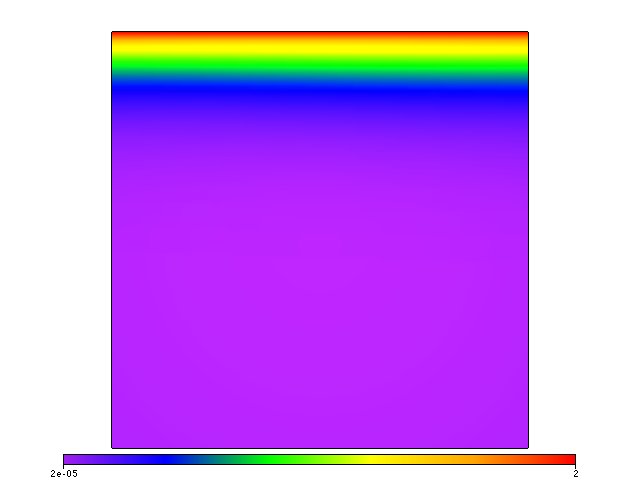

In [18]:
# lets take a look at the eta function
figEta = plt.Figure()
figEta.Surface(viscosityFn, linearMesh)
figEta.show()

##Build the Stokes system

In [20]:
# Setup a stokes system
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              etaFn=fn.exception.SafeMaths(viscosityFn), 
                              bodyForceFn=buoyancyFn )

In [22]:
# Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )
# Also create some integral objects which are used to calculate statistics.
v2sum_integral  = uw.utils.Integral( feMesh=linearMesh, fn=fn.math.dot(velocityField, velocityField) ) 
volume_integral = uw.utils.Integral( feMesh=linearMesh, fn=1. )

##Metrics for benchmark

For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [23]:
#uw.utils.Integral(temperatureField*velocityField[:,1])
dw = uw.utils.Integral(temperatureField*velocityField[1], linearMesh)

In [24]:
def avg_temp():
    temp = uw.utils.Integral(temperatureField, linearMesh)
    return temp.integrate()[0]

#def top_nuss():
#    temp = uw.utils.Integral(temperatureField, linearMesh)
    
def rms():
    squared = uw.utils.Integral(fn.math.dot(velocityField,velocityField), linearMesh)
    area = uw.utils.Integral(1.,linearMesh)
    return math.sqrt(squared.integrate()[0]/area.integrate()[0])

def rms_surf():
    xvelocityField = fn.math.dot(velocityField,np.array([1.,0.]))
    squared = uw.utils.Integral(fn.math.dot(topField, fn.math.dot(xvelocityField,xvelocityField)), linearMesh)
    toparea = uw.utils.Integral((topField*1.),linearMesh)
    return squared.integrate()[0]/toparea.integrate()[0]

def max_vx_surf():
    vsquare = velocityField.numpyArray.reshape(xnum+1,ynum+1,2)
    vxmax = vsquare[0,:,0].max()
    return vxmax

def gravwork():
    dw = uw.utils.Integral(temperatureField*velocityField[1], linearMesh)
    return dw.integrate()[0]


#There still might be something wrong here, given the contrasting versions of the second invariant
def viscdis():
    secinv = fn.tensor.second_invariant( 
                    fn.tensor.get_symmetric_part( 
                        velocityField.gradientFn ))
    temp = fn.math.dot(secinv,secinv)
    vd = uw.utils.Integral((4.*viscosityFn*temp), linearMesh)
    return vd.integrate()[0]
        

#linearMesh.specialSets["MinJ_VertexSet"]()

##solve with Picard iteration

In [25]:
# Stepping. Initialise time and timestep.
import time
realtime = 0.
step = 0
timevals = []
vrmsvals = []

In [26]:
# create integral to get diff 
diffFn = velocityFieldCopy - velocityField
diffInt = uw.utils.Integral( feMesh=linearMesh, fn=fn.math.dot(diffFn,diffFn) )

ToleranceValue = 1e-6
start = time.clock()
fname = "uw_results_case" + str(CASE) + ".dat"
f_o = open(os.path.join("./",fname), 'w')
# Perform steps
maxiter = 10
while step<1000:
    #Enter non-linear loop
    diff = ToleranceValue + 1.
    nlits = -1 #call the first solve a linear iteration
    while diff > ToleranceValue and nlits < maxiter:
        # store velocity of previous timestep on the feVaribale "velocityFieldCopy"
        velocityFieldCopy.numpyArray[:] = velocityField.numpyArray[:]
        stokesPIC.solve()
        diff = diffInt.integrate()[0]/v2sum_integral.integrate()[0]
        nlits += 1
        #print nlits,diff
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(time)
    # Calculate the Metrics
    Avg_temp = avg_temp()
    Rms = rms()
    Rms_surf = rms_surf()
    Max_vx_surf = max_vx_surf()
    Gravwork = gravwork()
    Viscdis = viscdis()
    #Just some testing stuff
    test5 = uw.utils.Integral(secinvCopy, linearMesh)
    # write output values to file
    f_o.write((9*'%-15s ' + '\n') % (realtime, 'NaN' , 'NaN' ,Viscdis, Avg_temp, Rms,Rms_surf,Max_vx_surf,Gravwork))
    if step % 10 == 0:
        print 'step =',step, 'nonlinear its', nlits, 'Rms =', Rms 
f_o.close()

step = 10 nonlinear its 4 Rms = 3.42393916743
step = 20 nonlinear its 4 Rms = 3.74168885806
step = 30 nonlinear its 4 Rms = 4.08475109194
step = 40 nonlinear its 4 Rms = 4.45501643086
step = 50 nonlinear its 4 Rms = 4.85483940538
step = 60 nonlinear its 5 Rms = 5.29101748609
step = 70 nonlinear its 5 Rms = 5.75775660909
step = 80 nonlinear its 3 Rms = 6.25791315895
step = 90 nonlinear its 5 Rms = 6.80824054791
step = 100 nonlinear its 3 Rms = 7.39228818773
step = 110 nonlinear its 3 Rms = 8.03313367643
step = 120 nonlinear its 3 Rms = 8.72941399902
step = 130 nonlinear its 1 Rms = 9.49503869764
step = 140 nonlinear its 1 Rms = 10.3231942773
step = 150 nonlinear its 1 Rms = 11.2303734202
step = 160 nonlinear its 1 Rms = 12.2281868998
step = 170 nonlinear its 1 Rms = 13.3325174616
step = 180 nonlinear its 1 Rms = 14.5586706273
step = 190 nonlinear its 1 Rms = 15.9304442937
step = 200 nonlinear its 1 Rms = 17.4782817778
step = 210 nonlinear its 1 Rms = 19.2657885478
step = 220 nonlinear i

##Sanity checks for yield behavior problem

* swapping viscosityl for viscosityp returns the same value as the linear viscosity...tested up to 300 timesteps
* set yield strength to 0.1 (a tenth) and 10 x defualt, to see if nonlinear its would increase...in fact they still die off (system seems to enter linear regime)
* Increase Rayleigh number...to do


#Figures

In [27]:
#switch off to run in Parallel

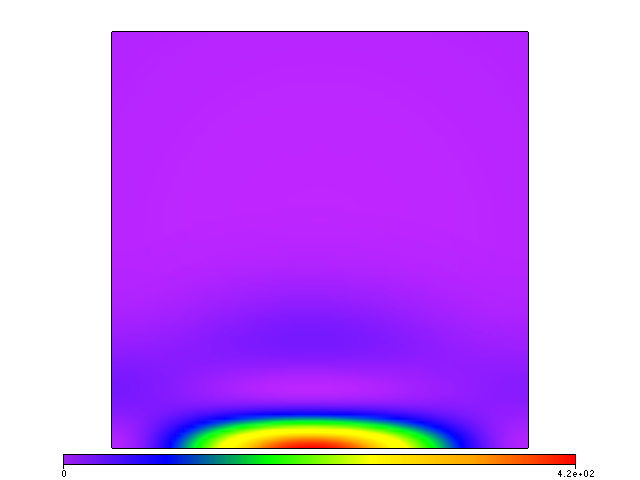

In [28]:
# lets check FEM solution
velMag = plt.Figure()
velMag.Surface(fn.math.dot(velocityField,velocityField), linearMesh)
velMag.show()

Figure 1. Steady state snapshots of temperature, viscosity, RMS velocity, second invariant of the stress tensor, and (right column) corresponding laterally averaged profiles for Case 1 obtained with the code Underworld. 

Figure 2.. As in Figure 1, but for Case 2... The four profiles can be found in the Data Set S2 of the supporting information.

#References

<a name="cite-tosi2015community"/><sup>[^](#ref-1) </sup>Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.



<!--bibtex

@article{tosi2015community,
  title={A community benchmark for viscoplastic thermal convection in a 2-D square box},
  author={Tosi, Nicola and Stein, Claudia and Noack, Lena and H{\"u}ttig, Christian and Maierov{\'a}, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others},
  journal={Geochemistry, Geophysics, Geosystems},
  year={2015},
  publisher={Wiley Online Library}
}

... Other Bibtex entries go here.

-->